In [1]:
import pandas as pd 
import numpy as np
import spacy
import regex as re
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import recall_score, f1_score,precision_score
import seaborn as sns
model_spacy = spacy.load('en_core_web_lg')

DATA Preprocessing

In [2]:
df = pd.read_csv('D:\\NLP\\project\\dataset\\df_m.csv')

In [3]:
df.head()

,text,anottator1,anottator2,anottator3,majority
0,@Cloudflare reports #ransom #DDoS attacks have...,Not_News,Not_News,Not_News,Not_News
1,Here’s the one thing you mustn’t tell hackers ...,Not_News,Not_News,Not_News,Not_News
2,@TactiKoolSec There was the time where a not-s...,Not_News,Not_News,Not_News,Not_News
3,Ransomware is a fast-growing threat impacting ...,Not_News,Not_News,Not_News,Not_News
4,Five key cloud and innovation takeaways from I...,Not_News,Not_News,Not_News,Not_News


In [4]:
df['majority'].value_counts()

majority
Not_News          31231
Normal_News        3948
High_Risk_News      892
Exluded               9
Name: count, dtype: int64

In [5]:
df['text'].isna().sum()

0

In [6]:
df['text'][0]

'@Cloudflare reports #ransom #DDoS attacks have dropped drastically in 2022, with 17% of its DDoS-targeted clients reporting an #extortion in Jan, 6% in Feb, and 3% in Mar 2022. @dynamicCISO #Ransomware #100DaysOfCode #Malware #GirlsWhoCode #InfoSec #cyberattacks #cybersecurity https://t.co/bXe7xZ6UPO'

In [7]:
df.count()

text          36080
anottator1    36080
anottator2    36080
anottator3    36080
majority      36080
dtype: int64

In [8]:
def checkstartwithSymbol(text):
    pattern = r'^[@!#$%^&*()_+={}\[\]:;"\'<>,.?/\\|`~]'
    if re.match(pattern, text):
        return True
    else:
        return False

In [9]:
def preprocessText(text):
    doc = model_spacy(text)
    new_doc = []
    for token in doc:
        if token.is_punct:
           continue 
        elif token.is_stop:
            continue
        elif checkstartwithSymbol(token.text):
            new_doc.append(token.text[1:])
        elif token.text.startswith('https://'):
            continue    
        elif '\n\n' == token.text or '\n'== token.text or '&gt;&gt'==token.text or '  '== token.text or ' ' == token.text or '.'==token.text or "''"==token.text:
            continue
        else:  
            new_doc.append(token.text.lower())
    return (' '.join(new_doc)).rstrip()        

In [10]:
def visualiseData():
    num = np.random.randint(0,36080)
    print(preprocessText(df['text'][num]))
    print()
    print("===========================================")
    print()
    print(df['text'][num])

In [11]:
visualiseData()

Breaking911 fake news russia china attacking suspect vise versa e mail created believe 100 true ransomware


@Breaking911 Fake news.. Russia and China have been attacking the US and I suspect vise versa since e-mail was created.. Believe me or not it’s 100% true.. Can you say ransomware??


In [12]:
df['Cleaned_Text'] = df['text'].apply(preprocessText) 

In [13]:
X = df['Cleaned_Text']
Y = df['majority'] 

Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
xtrain,xtest,ytrain,ytest = train_test_split(X,Y, test_size=0.2,random_state=42)

In [16]:
xtrain.shape,ytrain.shape

((28864,), (28864,))

Text Vectorization

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
countvectorizer = CountVectorizer(ngram_range=(1,3))


In [19]:
xtrain_vector = countvectorizer.fit_transform(xtrain)

In [20]:
xtrain_vector.shape

(28864, 434199)

In [21]:
(xtrain_vector[0]).toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [22]:
from sklearn.preprocessing import LabelEncoder
le_train = LabelEncoder()
ytrain_vector=le_train.fit_transform(ytrain)

In [23]:
ytrain_vector[0]

3

In [24]:
ytrain_vector.shape

(28864,)

In [25]:
xtest_vector = countvectorizer.transform(xtest)

In [26]:
ytest_vector = le_train.fit_transform(ytest)

SVM

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [28]:
svc = SVC(kernel='linear')
svc.fit(xtrain_vector,ytrain_vector)

SVC(kernel='linear')

In [29]:
predict_train_svc = svc.predict(xtrain_vector)

In [30]:
test_predict_svc = svc.predict(xtest_vector)

In [31]:
acc_svc_train = accuracy_score(ytrain_vector,predict_train_svc)
acc_svc_train

0.9979905764966741

In [32]:
acc_svc_test = accuracy_score(ytest_vector,test_predict_svc)
acc_svc_test

0.9717294900221729

In [33]:
cm_train_svc = confusion_matrix(ytrain_vector,predict_train_svc)

In [34]:
cm_test_svc = confusion_matrix(ytest_vector,test_predict_svc)

In [35]:
svc_train_report = classification_report(ytrain_vector,predict_train_svc)
print(svc_train_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.98      0.98      0.98       695
           2       0.99      0.99      0.99      3179
           3       1.00      1.00      1.00     24983

    accuracy                           1.00     28864
   macro avg       0.99      0.99      0.99     28864
weighted avg       1.00      1.00      1.00     28864



In [36]:
svc_test_report = classification_report(ytest_vector,test_predict_svc)
print(svc_test_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.84      0.78      0.81       197
           2       0.87      0.88      0.87       769
           3       0.99      0.99      0.99      6248

    accuracy                           0.97      7216
   macro avg       0.67      0.66      0.67      7216
weighted avg       0.97      0.97      0.97      7216



In [37]:
svc_precision = precision_score(ytest_vector, test_predict_svc, average='weighted')
svc_f1 = f1_score(ytest_vector, test_predict_svc, average='weighted')
svc_recall = recall_score(ytest_vector, test_predict_svc, average='weighted')
print(svc_precision)
print(svc_f1)
print(svc_recall)


0.971503933618418
0.971575535613425
0.9717294900221729


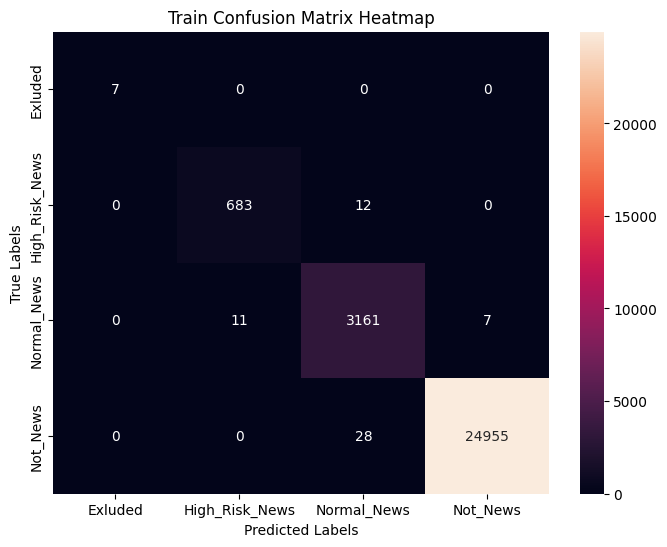

In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_svc , annot=True, fmt='d', 
            xticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'], 
            yticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Train Confusion Matrix Heatmap')

plt.show()

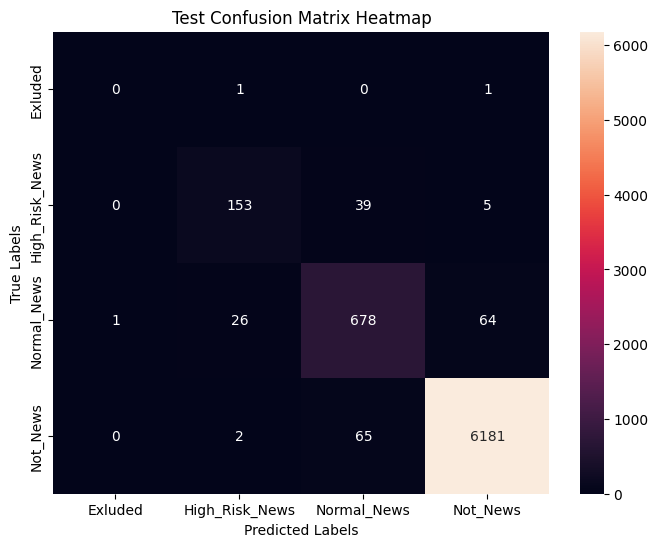

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_svc , annot=True, fmt='d', 
            xticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'], 
            yticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix Heatmap')

plt.show()

Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [41]:
lr.fit(xtrain_vector,ytrain_vector)

LogisticRegression()

In [42]:
lr_predict =  lr.predict(xtrain_vector)

In [43]:
test_predict =  lr.predict(xtest_vector)

In [44]:
lr_train_acc = accuracy_score(ytrain_vector,lr_predict)
lr_train_acc

0.9979559312638581

In [45]:
lr_test_acc = accuracy_score(ytest_vector,test_predict)
lr_test_acc

0.9742239467849224

In [46]:
cm_train_lr = confusion_matrix(ytrain_vector,lr_predict)

In [47]:
cm_test_lr = confusion_matrix(ytest_vector,test_predict)

In [48]:
lr_test_report = classification_report(ytrain_vector,lr_predict)
print(lr_test_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.99      0.98      0.98       695
           2       0.99      1.00      0.99      3179
           3       1.00      1.00      1.00     24983

    accuracy                           1.00     28864
   macro avg       0.99      0.99      0.99     28864
weighted avg       1.00      1.00      1.00     28864



In [49]:
lr_test_report = classification_report(ytest_vector,test_predict)
print(lr_test_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.88      0.75      0.81       197
           2       0.88      0.89      0.89       769
           3       0.99      0.99      0.99      6248

    accuracy                           0.97      7216
   macro avg       0.69      0.66      0.67      7216
weighted avg       0.97      0.97      0.97      7216



c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [50]:
lr_precision = precision_score(ytest_vector,test_predict, average='weighted')
lr_f1 = f1_score(ytest_vector,test_predict, average='weighted')
lr_recall = recall_score(ytest_vector,test_predict, average='weighted')
print(lr_precision)
print(lr_f1)
print(lr_recall)

0.973660565480443
0.9738061378902992
0.9742239467849224


c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


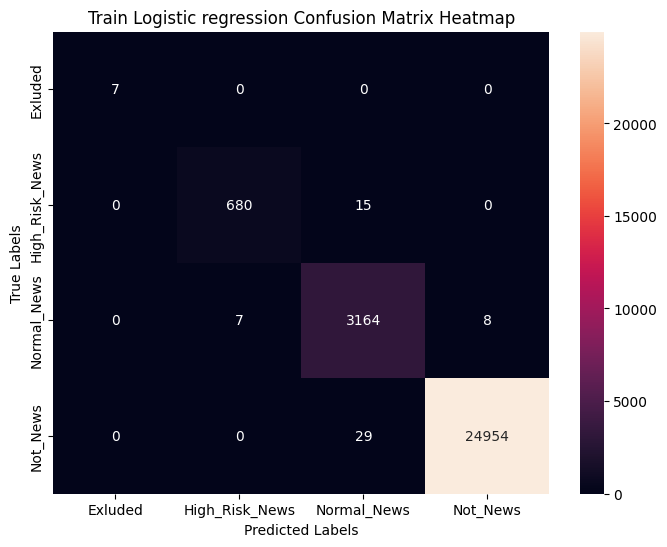

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_lr , annot=True, fmt='d', 
            xticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'], 
            yticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Train Logistic regression Confusion Matrix Heatmap')

plt.show()

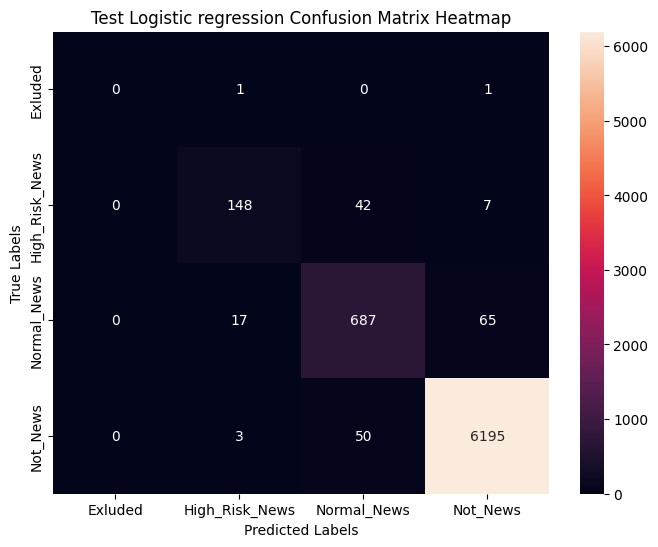

In [52]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_lr , annot=True, fmt='d', 
            xticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'], 
            yticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Logistic regression Confusion Matrix Heatmap')

plt.show()

Decision Tree

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
dt = DecisionTreeClassifier()
dt.fit(xtrain_vector,ytrain_vector)

DecisionTreeClassifier()

In [55]:
predict_train = dt.predict(xtrain_vector)

In [56]:
predict_test = dt.predict(xtest_vector)

In [57]:
acc_train_dt = accuracy_score(ytrain_vector,predict_train)
acc_train_dt

0.99802522172949

In [58]:
acc_test_dt = accuracy_score(ytest_vector,predict_test)
acc_test_dt

0.9588414634146342

In [59]:
report_train_dt = classification_report(ytrain_vector,predict_train)
report_test_dt = classification_report(ytest_vector,predict_test)

In [60]:
dt_precision = precision_score(ytest_vector,predict_test, average='weighted')
dt_f1 = f1_score(ytest_vector,predict_test, average='weighted')
dt_recall = recall_score(ytest_vector,predict_test, average='weighted')
print(dt_precision)
print(dt_f1)
print(dt_recall)

0.9586776930082757
0.9587055540724712
0.9588414634146342


In [61]:
print(report_train_dt)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.98      0.98      0.98       695
           2       0.99      1.00      0.99      3179
           3       1.00      1.00      1.00     24983

    accuracy                           1.00     28864
   macro avg       0.99      0.99      0.99     28864
weighted avg       1.00      1.00      1.00     28864



In [62]:
print(report_test_dt)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.80      0.73      0.76       197
           2       0.82      0.83      0.83       769
           3       0.98      0.98      0.98      6248

    accuracy                           0.96      7216
   macro avg       0.65      0.64      0.64      7216
weighted avg       0.96      0.96      0.96      7216



In [63]:
cm_train_dt =  confusion_matrix(ytrain_vector,predict_train)
cm_test_dt = confusion_matrix(ytest_vector,predict_test)

Text(0.5, 1.0, 'Confusion training decision tree Matrix Heatmap')

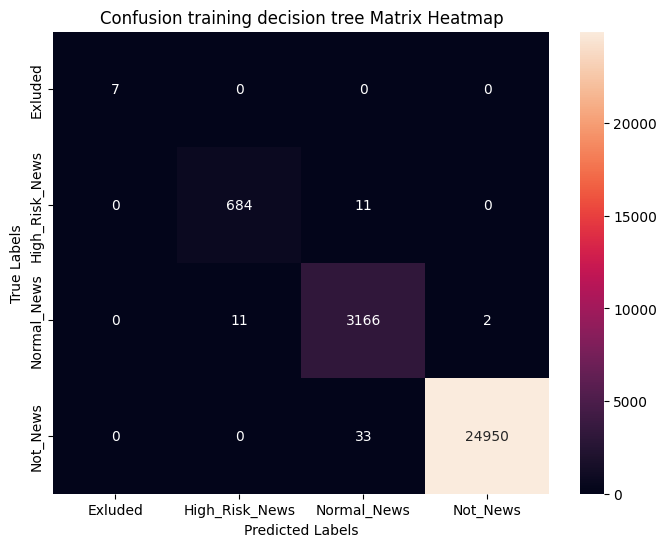

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_dt, annot=True, fmt='d', 
            xticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'], 
            yticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion training decision tree Matrix Heatmap')

Text(0.5, 1.0, 'Confusion testing decision tree Matrix Heatmap')

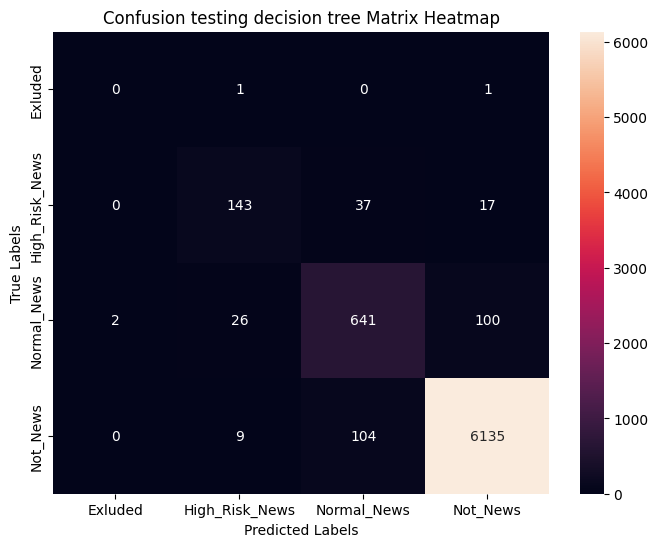

In [65]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_dt, annot=True, fmt='d', 
            xticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'], 
            yticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion testing decision tree Matrix Heatmap')

Naive Bayes

In [66]:
from sklearn.naive_bayes import MultinomialNB

In [67]:
NB = MultinomialNB()
NB.fit(xtrain_vector,ytrain_vector)

MultinomialNB()

In [68]:
predict_train = NB.predict(xtrain_vector)

In [69]:
predict_test = NB.predict(xtest_vector)

In [70]:
acc_train_nb = accuracy_score(ytrain_vector,predict_train)
acc_train_nb

0.9778616962305987

In [71]:
acc_test_nb = accuracy_score(ytest_vector,predict_test)
acc_test_nb

0.9657705099778271

In [72]:
report_train_nb = classification_report(ytrain_vector,predict_train)
report_test_nb = classification_report(ytest_vector,predict_test)

c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [73]:
nb_precision = precision_score(ytest_vector,predict_test, average='weighted')
nb_f1 = f1_score(ytest_vector,predict_test, average='weighted')
nb_recall = recall_score(ytest_vector,predict_test, average='weighted')
print(nb_precision)
print(nb_f1)
print(nb_recall)

0.9651536865904091
0.9649728878839752
0.9657705099778271


c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
print(report_train_nb)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.83      0.81      0.82       695
           2       0.88      0.97      0.92      3179
           3       1.00      0.98      0.99     24983

    accuracy                           0.98     28864
   macro avg       0.68      0.69      0.68     28864
weighted avg       0.98      0.98      0.98     28864



In [75]:
print(report_test_nb)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      0.67      0.77       197
           2       0.85      0.86      0.85       769
           3       0.98      0.99      0.99      6248

    accuracy                           0.97      7216
   macro avg       0.68      0.63      0.65      7216
weighted avg       0.97      0.97      0.96      7216



In [76]:
cm_train_nb =  confusion_matrix(ytrain_vector,predict_train)
cm_test_nb = confusion_matrix(ytest_vector,predict_test)

Text(0.5, 1.0, 'Confusion training NaiveBayes Matrix Heatmap')

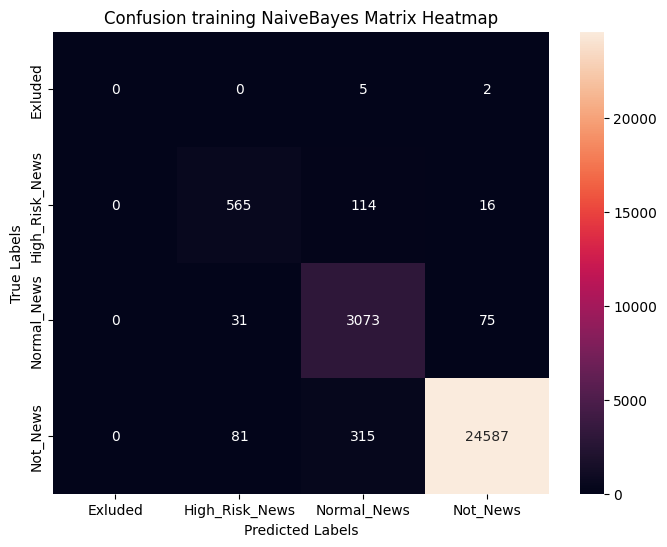

In [77]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_nb, annot=True, fmt='d', 
            xticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'], 
            yticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion training NaiveBayes Matrix Heatmap')

Text(0.5, 1.0, 'Confusion training NaiveBayes Matrix Heatmap')

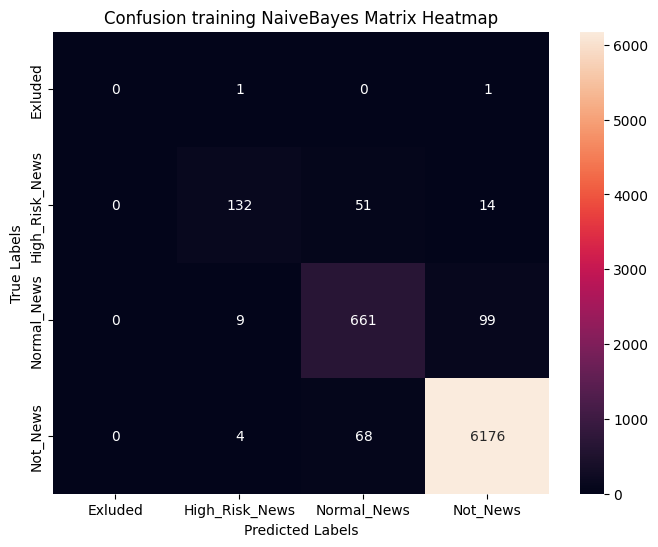

In [78]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_nb, annot=True, fmt='d', 
            xticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'], 
            yticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion training NaiveBayes Matrix Heatmap')

KNN

In [79]:
from sklearn.neighbors import KNeighborsClassifier

In [80]:
knn = KNeighborsClassifier(3)
knn.fit(xtrain_vector,ytrain_vector)

KNeighborsClassifier(n_neighbors=3)

In [81]:
predict_train = knn.predict(xtrain_vector)

In [82]:
predict_test = knn.predict(xtest_vector)

In [83]:
acc_train_knn = accuracy_score(ytrain_vector,predict_train)
acc_train_knn

0.9583217849223947

In [84]:
acc_test_knn = accuracy_score(ytest_vector,predict_test)
acc_test_knn

0.9469235033259423

In [85]:
report_train_knn = classification_report(ytrain_vector,predict_train)
report_test_knn = classification_report(ytest_vector,predict_test)

c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [86]:
knn_precision = precision_score(ytest_vector,predict_test, average='weighted')
knn_f1 = f1_score(ytest_vector,predict_test, average='weighted')
knn_recall = recall_score(ytest_vector,predict_test, average='weighted')
print(knn_precision)
print(knn_f1)
print(knn_recall)

0.9451658267907426
0.9419609067381974
0.9469235033259423


c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [87]:
print(report_train_knn)

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.91      0.80      0.85       695
           2       0.95      0.69      0.80      3179
           3       0.96      1.00      0.98     24983

    accuracy                           0.96     28864
   macro avg       0.96      0.66      0.72     28864
weighted avg       0.96      0.96      0.96     28864



In [88]:
print(report_test_knn)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      0.66      0.77       197
           2       0.92      0.62      0.74       769
           3       0.95      1.00      0.97      6248

    accuracy                           0.95      7216
   macro avg       0.69      0.57      0.62      7216
weighted avg       0.95      0.95      0.94      7216



In [89]:
cm_train_knn =  confusion_matrix(ytrain_vector,predict_train)
cm_test_knn = confusion_matrix(ytest_vector,predict_test)

Text(0.5, 1.0, 'Confusion training KNN Matrix Heatmap')

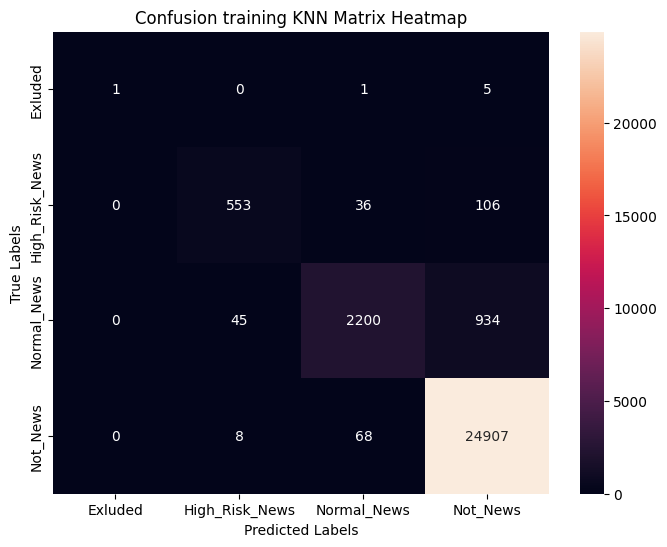

In [90]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_knn, annot=True, fmt='d', 
            xticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'], 
            yticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion training KNN Matrix Heatmap')

Text(0.5, 1.0, 'Confusion testing KNN Matrix Heatmap')

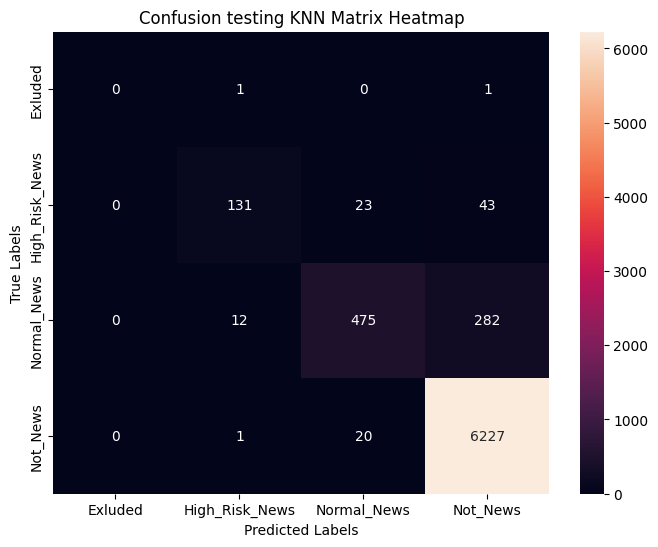

In [91]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_knn, annot=True, fmt='d', 
            xticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'], 
            yticklabels=['Exluded', 'High_Risk_News', 'Normal_News', 'Not_News'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion testing KNN Matrix Heatmap')

In [92]:
x_data = [round(acc_svc_test,3),round(lr_test_acc,3),round(acc_test_dt,3),round(acc_test_nb,3),round(acc_test_knn,3)]
y_data = ['SVM','Logistic Regression','Decision Tree','Naive Bayes','KNN']

In [93]:
px.bar(x=y_data,y=x_data,title="Models test accuracy curve with Count Vectorization",labels={'x':'models','y':'accuracy'})

In [94]:
px.line(x=y_data,y=x_data,title="Models test accuracy curve with Count Vectorization",labels={'x':'models','y':'accuracy'},markers='o')

In [95]:
x_data_precision = [svc_precision,lr_precision,dt_precision,nb_precision,knn_precision]
px.line(x=y_data,y=x_data_precision,title="Models test precision curve with Count Vectorization",labels={'x':'models','y':'Precision'},markers='o')

In [96]:
x_data_f1 = [svc_f1,lr_f1,dt_f1,nb_f1,knn_f1]
px.line(x=y_data,y=x_data_precision,title="Models test f1-score curve with Count Vectorization",labels={'x':'models','y':'F1-Score'},markers='o')

In [97]:
x_data_recall = [svc_recall,lr_recall,dt_recall,nb_recall,knn_recall]
px.line(x=y_data,y=x_data_precision,title="Models test recall curve with Count Vectorization",labels={'x':'models','y':'recall'},markers='o')

In [98]:
d = {'models':y_data,'ngrams':'(1,3)','Text_vectorization':'BOW(CountVectorizer)','accuracy_score':x_data,'precision_score':x_data_precision,'f1_score':x_data_f1,'recall_score':x_data_recall}
data = pd.DataFrame(d)
data.to_csv('count_(1,3).csv',index=False)

In [99]:
data

,models,ngrams,Text_vectorization,accuracy_score,precision_score,f1_score,recall_score
0,SVM,"(1,3)",BOW(CountVectorizer),0.972,0.971504,0.971576,0.971729
1,Logistic Regression,"(1,3)",BOW(CountVectorizer),0.974,0.973661,0.973806,0.974224
2,Decision Tree,"(1,3)",BOW(CountVectorizer),0.959,0.958678,0.958706,0.958841
3,Naive Bayes,"(1,3)",BOW(CountVectorizer),0.966,0.965154,0.964973,0.965771
4,KNN,"(1,3)",BOW(CountVectorizer),0.947,0.945166,0.941961,0.946924
